<a href="https://colab.research.google.com/github/Raaazzy/linguistics/blob/main/program.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Необходимо построить дерево по матрице расстояний.

На вход подается двумерный массив. <br>
На выходе получается графическое отображение дерева и скобочная последовательность вида (((D:95,C:95):89,B:89):61,A:61), где: <br>
A, B, C, D - это листья дерева, <br>
Числами обозначается процент схожести языков/слов или любых других элементов, <br>
В скобки заключены связанные листья дерева. <br>

Устанавливаем и импортируем необходимые библиотеки

In [ ]:
!pip install Bio

import copy
import numpy as np
from Bio import Phylo
from io import StringIO

Метод необходимый для нахождения максимального значения в матрице. <br>
На вход подается:
- matrix - ненулевая матрица с нулевой главной диагональю.<br>
Метод возвращает:
- max_i - номер строки, в которой находится максимум;<br>
- max_j - номер столбца, в котором находится максимум;<br>
- max_val - максимальное значение.<br>

In [ ]:
def find_max_distance(matrix):
    max_val = 0
    max_i, max_j = -1, -1
    # Пробегаемся по всем значениям нижнего треугольника матрицы
    for i in range(len(matrix)):
        for j in range(i):
          # Если текущий элемент матрицы больше нашего максимума, то запоминаем его
            if matrix[i][j] > max_val:
                max_val = matrix[i][j]
                max_i, max_j = i, j
    return max_i, max_j, max_val

Метод для нахождения списка всех одинаково максимальных значений в заданной матрице.<br>
На вход подается ненулевая матрица с нулевой главной диагональю.<br>
Метод возвращает:
- max_pairs_ij - список положений максимальных значений матрицы;
- max_val - максимальное значение.<br>

In [282]:
def find_all_max_distances(matrix):
    _, _, max_val = find_max_distance(matrix)
    max_pairs_ij = []
    # Пробегаемся по всем значениям нижнего треугольника матрицы
    for i in range(len(matrix)):
        for j in range(i):
          # Если текущий элемент матрицы равен максимуму, то закидываем его в массив
            if matrix[i][j] == max_val:
                max_pairs_ij.append((i, j))
    return max_pairs_ij, max_val

Метод для осуществление алгоритма UPGMA, необходимого для подсчета расстояний между листьями деревьев.<br>
На вход подается:<br>
 - matrix - ненулевая матрица с нулевой главной диагональю;<br>
 - clusters - переменная хранящая запись скобочной последовательности будущего дерева;<br>
 - i - номер строки;<br>
 - j - номер столбца;<br>
 - max_val - максимальное значение в данной матрице.<br>

Метод возвращает:
 - matrix - ненулевая преобразованная матрица с нулевой главной диагональю;<br>
 - clusters - преобразованная переменная хранящая запись скобочной последовательности будущего дерева;<br>

In [283]:
def merge_ij(matrix, clusters, i, j, max_val):
    # Создаем копии матрицы и списка кластеров
    work_matrix = copy.deepcopy(matrix)
    work_clusters = copy.deepcopy(clusters)

    # Вносим изменения в копии матрицы и списка кластеров
    work_clusters[i] = f"({work_clusters[i]}:{max_val},{work_clusters[j]}:{max_val})"
    work_clusters = work_clusters[:j] + work_clusters[j + 1:]

    #work_clusters = np.delete(work_clusters, j)

    #del work_clusters[j]

    #mask = np.ones(len(work_clusters), dtype=bool)
    #mask[j] = False

    for k in range(len(work_matrix)):
        if k != i and k != j:
            work_matrix[i][k] = work_matrix[k][i] = (work_matrix[i][k] + work_matrix[j][k]) / 2

    # Удаляем строки и столбцы из копии матрицы
    work_matrix = np.delete(work_matrix, j, axis=0)
    work_matrix = np.delete(work_matrix, j, axis=1)

    #work_clusters = work_clusters[mask]

    # Возвращаем измененную матрицу и список кластеров
    return work_matrix, work_clusters


Метод, необходимый для выявления всех возможных деревьев для данной матрицы.<br>
На вход подается:<br>
 - matrix - ненулевая матрица с нулевой главной диагональю;<br>
 - clusters - переменная хранящая запись скобочной последовательности будущего дерева.<br>

Метод возвращает:
 - res - скобочные последовательности для будущего построения деревьев.<br>

In [ ]:
def multi_upgma_step(matrix, clusters):
    # Базовый случай: если остался один кластер, возвращаем его как результат
    if len(clusters) == 1:
        return clusters

    # Создаем глубокую копию матрицы расстояний для работы внутри текущего вызова
    work_matrix = np.array(copy.deepcopy(matrix), dtype=float)

    # Находим все пары с максимальными расстояниями и значение максимального расстояния
    max_pairs, max_val = find_all_max_distances(work_matrix)

    res = []
    # Перебираем все пары с максимальными расстояниями
    for i, j in max_pairs:
        # Выполняем объединение кластеров i и j
        new_matrix, new_clusters = merge_ij(work_matrix[:], clusters[:], i, j, max_val)

        # Рекурсивно вызываем эту же функцию для новой матрицы и кластеров
        for new_tree in multi_upgma_step(new_matrix, new_clusters):
            res.append(new_tree)

    return res

Метод, в котором происходит предобработка и проверка данных, а также старт выполнения основного алгоритма.<br>
На вход подается:<br>
 - matrix - ненулевая матрица с нулевой главной диагональю;<br>
 - labels - названия листьев.<br>

Метод возвращает:
 - res - конечные скобочные последовательность для данной матрицы.<br>

In [ ]:
def start_multi_upgma(matrix, labels):
    # Инициализируем кластеры начальными метками
    clusters = labels

    # Если матрица содержит более одного элемента, симметризуем её
    if len(matrix) > 1:
        for i in range(len(matrix)):
            for j in range(i):
                # Делаем матрицу симметричной, выбирая максимальное значение между matrix[i][j] и matrix[j][i]
                matrix[i][j] = matrix[j][i] = max(matrix[i][j], matrix[j][i])

    # Запускаем многоэтапный алгоритм UPGMA
    res = multi_upgma_step(matrix, clusters)

    return res

## Тестовые данные

((D:95.0,C:95.0):91.5,(B:96.0,A:96.0):91.5)


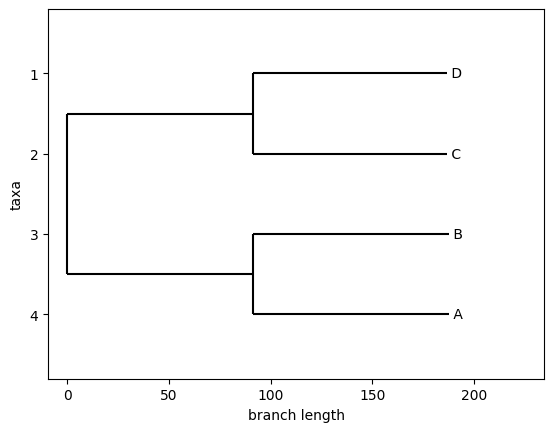

(D:90.0,((C:96.0,A:96.0):94.0,B:94.0):90.0)


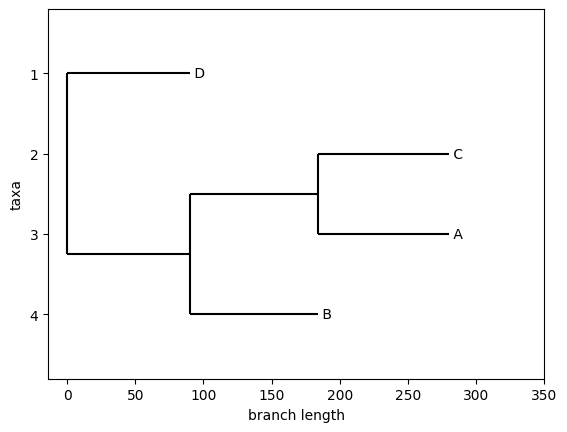

In [285]:
matrix_first_example = np.array([
    [0, 96, 96, 91],
    [96, 0, 92, 87],
    [96, 92, 0, 95],
    [91, 87, 95, 0]])

labels_first_example = ['A', 'B', 'C', 'D']

result = start_multi_upgma(matrix_first_example, labels_first_example)

for res in result:
  print(res)
  tree = Phylo.read(StringIO(res), "newick")
  Phylo.draw(tree)


((D:95.0,C:95.0):91.5,(B:96.0,A:96.0):91.5)


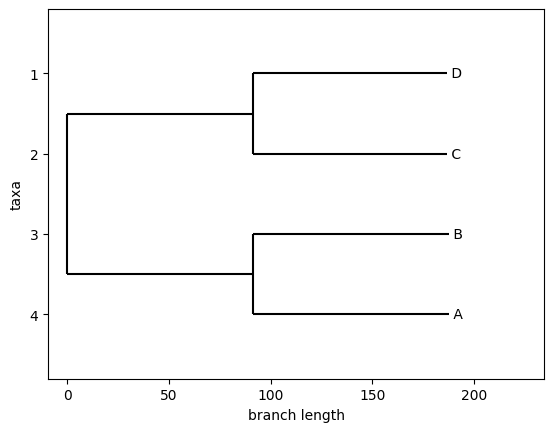

(D:90.0,((C:96.0,A:96.0):94.0,B:94.0):90.0)


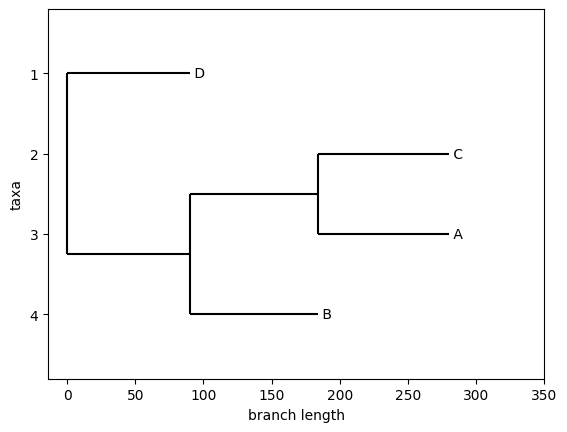

In [ ]:
matrix_second_example = np.array([
    [0, 96, 96, 91],
    [0, 0, 92, 87],
    [0, 0, 0, 95],
    [0, 0, 0, 0]])

labels_second_example = ['A', 'B', 'C', 'D']

result = start_multi_upgma(matrix_second_example, labels_second_example)

for res in result:
  print(res)
  tree = Phylo.read(StringIO(res), "newick")
  Phylo.draw(tree)


((D:95.0,C:95.0):91.5,(B:96.0,A:96.0):91.5)


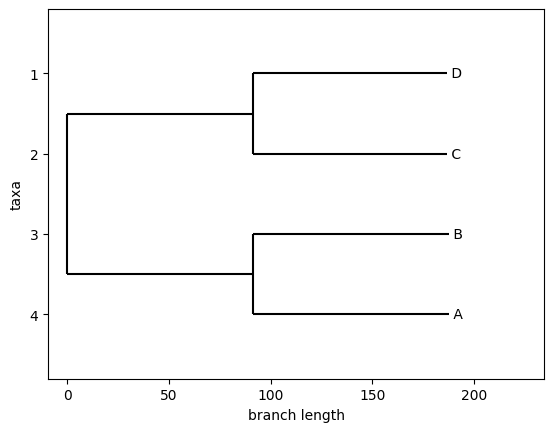

(D:90.0,((C:96.0,A:96.0):94.0,B:94.0):90.0)


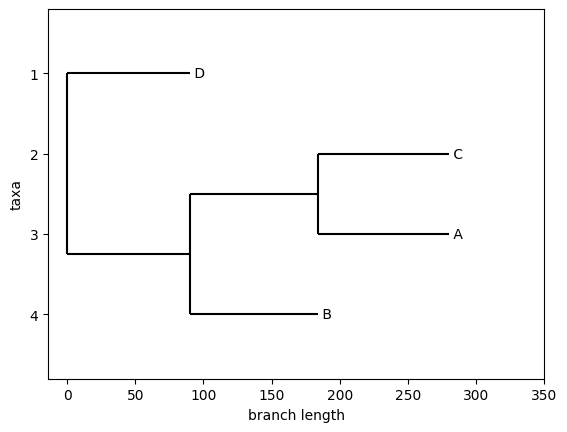

In [ ]:
matrix_third_example = np.array([
    [0, 0, 0, 0],
    [96, 0, 0, 0],
    [96, 92, 0, 0],
    [91, 87, 95, 0]])

labels_third_example = ['A', 'B', 'C', 'D']

result = start_multi_upgma(matrix_third_example, labels_third_example)

for res in result:
  print(res)
  tree = Phylo.read(StringIO(res), "newick")
  Phylo.draw(tree)


((F:99.0,B:99.0):2.1875,(((E:12.0,A:12.0):6.5,C:6.5):3.75,D:3.75):2.1875)


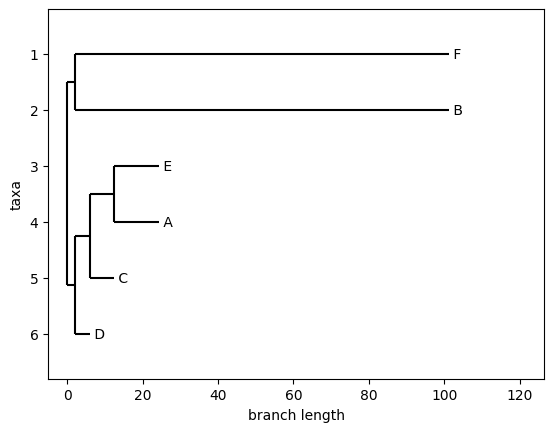

((F:99.0,B:99.0):2.1875,(((E:12.0,A:12.0):6.5,D:6.5):3.75,C:3.75):2.1875)


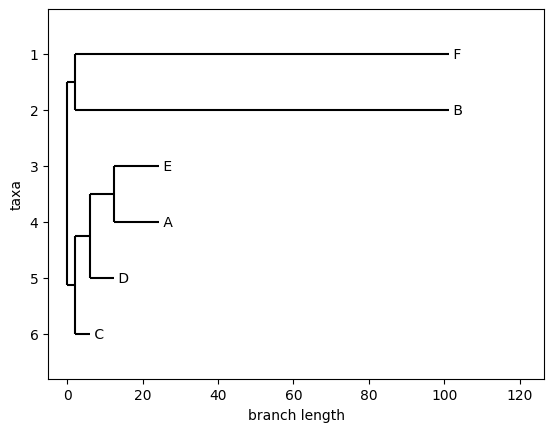

((F:99.0,B:99.0):2.1875,(((E:12.0,C:12.0):6.5,A:6.5):3.75,D:3.75):2.1875)


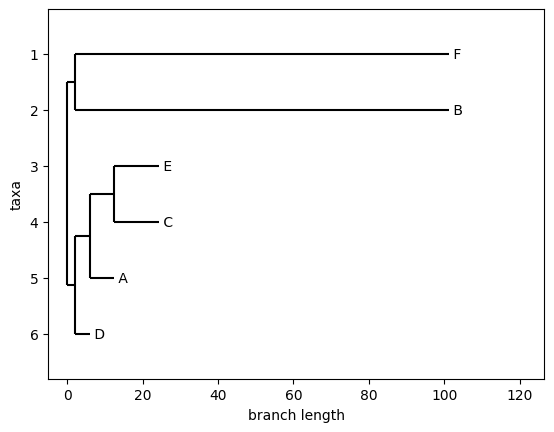

((F:99.0,B:99.0):2.1875,(((E:12.0,C:12.0):6.5,D:6.5):3.75,A:3.75):2.1875)


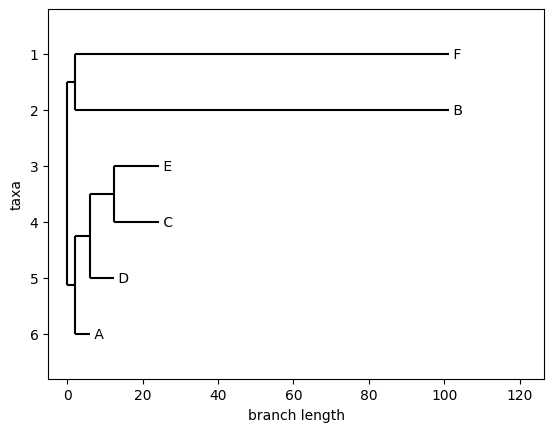

((F:99.0,B:99.0):2.1875,(((E:12.0,D:12.0):6.5,A:6.5):3.75,C:3.75):2.1875)


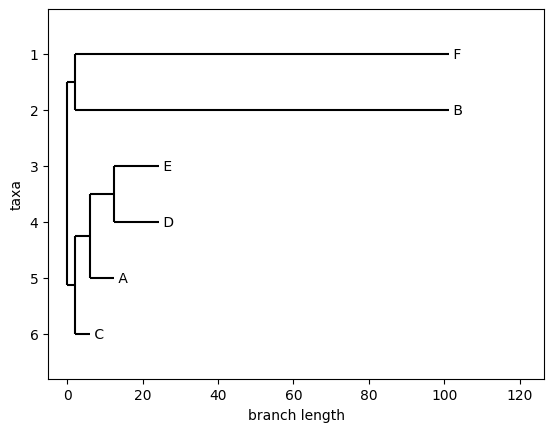

((F:99.0,B:99.0):2.1875,(((E:12.0,D:12.0):6.5,C:6.5):3.75,A:3.75):2.1875)


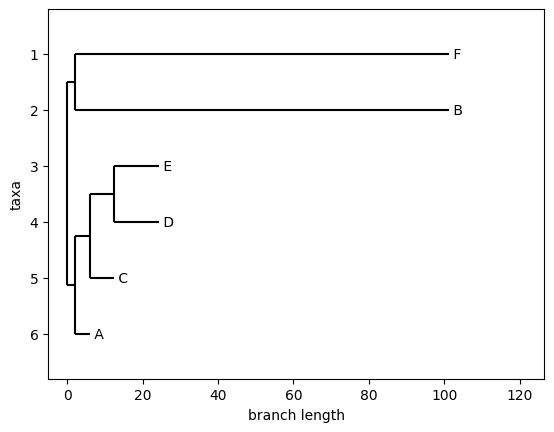

In [284]:
fourth_example = [
    [0,1,1,1,12,2],
    [1,0,1,1,12,99],
    [1,1,0,1,12,2],
    [1,1,1, 0,12,2],
    [12,12,12,12,0,2],
    [2,99,2,2,2,0],
]
labels_fourth_example = ['A', 'B', 'C', 'D', 'E', 'F']

result = start_multi_upgma(fourth_example, labels_fourth_example)

for res in result:
  print(res)
  tree = Phylo.read(StringIO(res), "newick")
  Phylo.draw(tree)

In [286]:
import pandas as pd

# Чтение CSV файла с использованием pandas
df = pd.read_csv('example_1.csv', sep=',')

# Получение одномерного массива названий столбцов (первая строка файла)
labels_fifths_example = df.columns[1:].to_numpy()
fifths_example = np.array(labels_fifths_example)

# Получение двумерного массива чисел
qwe = df.iloc[:, 1:].to_numpy(dtype=float)
fifths_example = np.array(qwe, dtype=float)

result = start_multi_upgma(fifths_example, labels_fifths_example)

for res in result:
  print(res)
  tree = Phylo.read(StringIO(res), "newick")
  Phylo.draw(tree)

ValueError: operands could not be broadcast together with shapes (12,) (8,) 